In [2]:
# If not already in your environment, install necessary packages.
#!pip install pickle, scipy

In [4]:
%run common_functions.ipynb
%run plotting_functions.ipynb

In [2]:
import math
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import pickle
from scipy.stats import zscore, pearsonr, mannwhitneyu
from random import sample

In [10]:
p_val = 0.01
n_lags = 3  # number of lags for GC

# Hindbrain dataset

In [4]:
data_path = '../data_paper/hindbrain/'
with open(data_path + 'df_hindbrain_F6T07.pkl', 'rb') as pickle_in:
    df_hindbrain = pickle.load(pickle_in)  

with open(data_path + 'xaxes_and_stim.npy', 'rb') as f:
    xAx_calcium = np.load(f)
    xAx_tail = np.load(f)
    xAx_stimulus = np.load(f)
    stim = np.load(f)
    
stim_start = xAx_stimulus[np.array([i for i in range(1, len(stim)) if stim[i] > 0 and stim[i-1] == 0])]
stim_end = xAx_stimulus[np.array([i for i in range(len(stim)-1) if stim[i] > 0 and stim[i+1] == 0])]


fish = 6
trace = '07'
background = df_hindbrain.background  # background for plotting

cell_centers = df_hindbrain.cell_centers  # position of cells on the background
n_cells = len(cell_centers)  # number of cells
n_pairs = n_cells * (n_cells - 1)

swim_neurons = df_hindbrain.swim_neurons  # index of motor-correlated neurons
n_cells_swim = len(swim_neurons)  # number of motor-correlated neurons
n_pairs_swim = n_cells_swim * (n_cells_swim - 1)

medial_neurons = df_hindbrain.medial_neurons  # index of motor-correlated neurons in the medial region
n_cells_med = len(medial_neurons)  # number of motor-correlated neurons in the medial region
n_pairs_med = n_cells_med * (n_cells_med - 1)

only_swim_neurons = df_hindbrain.only_swim_neurons  # index of motor-correlated neurons not in the medial region

other_neurons = np.arange(n_cells)

for i, n in enumerate(other_neurons):
    if n in swim_neurons:
        other_neurons[i] = -1
other_neurons = other_neurons[other_neurons>=0]

t_cycles = [round(5.81*(5+i*15)) for i in range(20)]  # start times of stimulus epochs

n_timesteps = t_cycles[-1] - t_cycles[0]  # 1656 timesteps corresponding to the 19 stimulus epochs
                                          # not 1744 that is the length of the whole recording
                                          # we keep 1656 for original GC to be coherent with shuffled GC

In [8]:
df_hindbrain

fluo                             [[-0.77609605, -0.7131812, -0.51290274, -0.639...
cell_centers                     [[214.0, 183.0], [232.0, 66.0], [214.0, 216.0]...
background                       [[31.38528823852539, 31.70622682571411, 33.918...
n_cells                                                                        139
tail_angle                       [-0.17017955, 0.18995744, 0.35838464, 0.0, -0....
tail_angle_regressor             [-0.954902181360471, -0.9516817209675773, -0.9...
is_swim                          [False, False, True, True, True, False, False,...
swim_neurons                     [2, 3, 4, 8, 9, 12, 17, 18, 20, 23, 25, 26, 30...
medial_neurons                   [8, 12, 23, 30, 36, 47, 52, 74, 79, 85, 86, 88...
SNR                              [12.293984700341193, 11.241579781467417, 11.78...
BV_GC_medial                     [[nan, 0.05621235126832501, 0.1447238764192729...
BV_Fstat_medial                  [[nan, 32.780420871867356, 86.59151395401796, ...
BV_t

In [12]:
# BVGC

"""
    Run bivariate GC on original fluorescence traces.
    Then shuffle the driving neuron's trace nmc times to generate a new null hypothesis for testing whether
    a link is significant or not.
    If you just want to plot the figures, you can skip this and use the data already in df_hindbrain.
"""

dfn = n_lags
dfd_BV = n_timesteps - 3 * n_lags - 1  # 2 cells involved + 1

# For other GCs
# dfd_cBV = n_timesteps - 4 * n_lags - 1  # 2 cells involved + stimulus + 1
# dfd_MV = n_timesteps - (n_cells_med + 1) * n_lags - 1  # n_cells_med involved +1
# dfd_cMV = n_timesteps - (n_cells_med + 2) * n_lags - 1  # n_cells_med involved + stimulus + 1

# original threshold
threshold_F_ori = stats.f.ppf(1 - p_val/n_pairs_med, dfn, dfd_BV) # Bonferroni corrected, common for all pairs

# If you replace by your own signals, make sure it is a np array of shape [n_cells, n_timesteps].
# The length should be the same for all neurons.
signals = df_hindbrain.fluo 

# original GC analysis on original signals
# only use 1656 timesteps to match the length of shuffled data (according to stimulus)
_, gc, fstat, _ = bivariateLinearCausalityTE(signals[medial_neurons, t_cycles[0]:t_cycles[-1]])

"""
Using bivariateLinearCausalityTE is much faster (0.32s for 20 neurons vs 6.23s) than doing:

for i, neuron1 in enumerate(medial_neurons):
    for j, neuron2 in enumerate(medial_neurons):
        if i != j: 
            signal1 = signals[neuron1][t_cycles[0]:t_cycles[-1]]  
            signal2 = signals[neuron2][t_cycles[0]:t_cycles[-1]]
            
            _, GC, Fstat, _ = bvgc_2_signals(signal1, signal2, n_lags=n_lags, pval=p_val)
            
            
If you don't have time, you may shuffle all signals and call bivariateLinearCausalityTE(signals_shuffled),
but this will be too permissive and you will still obtain spurious links.
"""

# Shuffles to get new null hypothesis.
# number of random shuffles - 100 should be enough. 
nmc = 1000  

all_gcs_sh = np.zeros([n_cells_med, n_cells_med, nmc])  # GC matrices for each shuffle
all_fstats_sh = np.zeros([n_cells_med, n_cells_med, nmc])  # Fstat matrices for each shuffle

for i, neuron1 in enumerate(medial_neurons):
    for j, neuron2 in enumerate(medial_neurons):
        if i != j: 
            signal2 = signals[neuron2][t_cycles[0]:t_cycles[-1]]
            
            # Shuffle signal1 nmc times, maintaining the structure of stimulus epochs.
            # If there is no stimulus, you can simply shift the array by different random numer of 
            # timesteps (see motoneuron example)
            for n in range(nmc):
                # BVGC
                signal1_sh = shuffle_signal(signals[neuron1], t_cycles)  # shuffle driving signal
                _, GC, Fstat, _ = bvgc_2_signals(signal1_sh, signal2, n_lags=n_lags, pval=p_val)

                all_gcs_sh[i][j][n] = GC
                all_fstats_sh[i][j][n] = Fstat
        else:
            for n in range(nmc):
                all_gcs_sh[i][j][n] = np.nan
                all_fstats_sh[i][j][n] = np.nan


                
# rescale
mean_F_sh = np.nanmean(all_fstats_sh, axis=2)
all_fstats_sh_rescaled = np.zeros([n_cells_med, n_cells_med, nmc])

for i in range(n_cells_med):
    for j in range(n_cells_med):
        if i != j:
            for k in range(nmc):
                all_fstats_sh_rescaled[i,j,k] = all_fstats_sh[i,j,k] / mean_F_sh[i,j] # follows F distribution
        else:
            for k in range(nmc):
                all_fstats_sh_rescaled[i,j,k] = np.nan

# we noticed that the distribution of Fstats on shuffled signals is well-described by a constant-rescaled F-distribution
# this might not be true for your data.
# if it looks like a shifted F-distribution, you can fit the correct parameter as described in the motoneuron example
threshold_F_new = mean_F_sh * threshold_F_ori  # customized threshold
fstat_normalized = fstat / mean_F_sh

# For hindbrain:
t_regr = n_timesteps - n_lags # = 1653 because 1656 timesteps taken not 1744
#     BVGC
#         dof_full = 2 * n_lags = 6
#         dof_reduced = n_lags = 3
#     cBVGC
#         dof_full = 3 * n_lags = 9
#         dof_reduced = 2 * n_lags = 6
#     MVGC
#         dof_full = n_rois * n_lags = 60
#         dof_reduced = (n_rois - 1) * n_lags = 57
#     cMVGC
#         dof_full =  (n_rois + 1) * n_lags = 63
#         dof_reduced = n_rois * n_lags = 60

gc_normalized = get_GC_from_Fstat(fstat_normalized, 2*n_lags, n_lags, t_regr) # normalized GC



C:\Users\FAUSTI~1.GIN\AppData\Local\Temp/ipykernel_25396/2950903952.py:79: RuntimeWarning: Mean of empty slice
  mean_F_sh = np.nanmean(all_fstats_sh, axis=2)


In [25]:
# MVGC
"""
    Run multivariate GC on original fluorescence traces.
    Then shuffle the driving neuron's trace nmc times to generate a new null hypothesis for testing whether
    a link is significant or not. This takes a lot of time (MVGC takes much more time than BVGC if you have
    a lot of neurons).
    If you just want to plot the figures, you can skip this and use the data already in df_hindbrain.
"""

dfn = n_lags  # same as for BVGC
dfd_MV = n_timesteps - (n_cells_med + 1) * n_lags - 1  # n_cells_med involved +1

# For other GCs
# dfd_BV = n_timesteps - 3 * n_lags - 1  # 2 cells involved + 1
# dfd_cBV = n_timesteps - 4 * n_lags - 1  # 2 cells involved + stimulus + 1
# dfd_cMV = n_timesteps - (n_cells_med + 2) * n_lags - 1  # n_cells_med involved + stimulus + 1

MV_threshold_F_ori = stats.f.ppf(1 - p_val/n_pairs_med, dfn, dfd_MV) # Bonferroni corrected, common for all pairs

# If you replace by your own signals, make sure it is a np array of shape [n_cells, n_timesteps].
# The length should be the same for all neurons.
signals = df_hindbrain.fluo 

# original GC analysis on original signals
# only use 1656 timesteps to match the length of shuffled data (according to stimulus)
_, MV_gc, MV_fstat, _ = multivariateLinearCausalityTE(signals[medial_neurons, t_cycles[0]:t_cycles[-1]])
"""
Using multivariateLinearCausalityTE is much faster (1s for 20 neurons vs 57s) than doing:

for i, neuron1 in enumerate(medial_neurons):
    for j, neuron2 in enumerate(medial_neurons):
        if i != j: 
            # original GC analysis on original signals
            # only use 1656 timesteps to match length of shuffled data 
            signal1 = signals[neuron1][t_cycles[0]:t_cycles[-1]]  
            signal2 = signals[neuron2][t_cycles[0]:t_cycles[-1]]
            
            small = min(i, j)
            large = max(i, j)
            z_indices = np.r_[0:small, small + 1:large, large + 1:n_cells_med]
            # OR z_indices = [k for k in range(n_rois) if k not in [i, j]]
            Z_set = signals[medial_neurons[z_indices], t_cycles[0]:t_cycles[-1]]
                       
            _, GC, Fstat, _ = mvgc_2_signals(signal1, signal2, Z_set, n_lags=n_lags, pval=p_val)
            MV_gc[i][j] = GC
            MV_fstat[i][j] = Fstat
            
If you don't have time, you may shuffle all signals and call multivariateLinearCausalityTE(signals_shuffled),
but this will be too permissive and you will still obtain spurious links.
"""

# number of random shuffles - 100 should be enough.
nmc = 100 

MV_all_gcs_sh = np.zeros([n_cells_med, n_cells_med, nmc])  # GC matrices for each shuffle
MV_all_fstats_sh = np.zeros([n_cells_med, n_cells_med, nmc])  # Fstats matrices for each shuffle

for i, neuron1 in enumerate(medial_neurons):
    for j, neuron2 in enumerate(medial_neurons):
        if i != j: 
            signal2 = signals[neuron2][t_cycles[0]:t_cycles[-1]]
            
            small = min(i, j)
            large = max(i, j)
            z_indices = np.r_[0:small, small + 1:large, large + 1:n_cells_med]
            # OR z_indices = [k for k in range(n_rois) if k not in [i, j]]
            Z_set = signals[medial_neurons[z_indices], t_cycles[0]:t_cycles[-1]]
            
            # Shuffle signal1 nmc times            
            for n in range(nmc):
                # MVGC
                signal1_sh = shuffle_signal(signals[neuron1], t_cycles)  # shuffle driving signal
                _, GC, Fstat, _ = mvgc_2_signals(signal1_sh, signal2, Z_set, n_lags=n_lags, pval=p_val)

                MV_all_gcs_sh[i][j][n] = GC
                MV_all_fstats_sh[i][j][n] = Fstat
        else:
            for n in range(nmc):
                MV_all_gcs_sh[i][j][n] = np.nan
                MV_all_fstats_sh[i][j][n] = np.nan

# rescale
MV_mean_F_sh = np.nanmean(MV_all_fstats_sh, axis=2)
MV_all_fstats_sh_rescaled = np.zeros([n_cells_med, n_cells_med, nmc])

for i in range(n_cells_med):
    for j in range(n_cells_med):
        if i != j:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = MV_all_fstats_sh[i,j,k] / MV_mean_F_sh[i,j] # follows F distribution
        else:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = np.nan

# customized threshold
MV_threshold_F_new = MV_mean_F_sh * MV_threshold_F_ori
MV_fstat_normalized = MV_fstat / MV_mean_F_sh

# For hindbrain:
t_regr = n_timesteps - n_lags # = 1653 because 1656 timesteps taken not 1744
#     BVGC
#         dof_full = 2 * n_lags = 6
#         dof_reduced = n_lags = 3
#     cBVGC
#         dof_full = 3 * n_lags = 9
#         dof_reduced = 2 * n_lags = 6
#     MVGC
#         dof_full = n_rois * n_lags = 60
#         dof_reduced = (n_rois - 1) * n_lags = 57
#     cMVGC
#         dof_full =  (n_rois + 1) * n_lags = 63
#         dof_reduced = n_rois * n_lags = 60
    
MV_gc_normalized = get_GC_from_Fstat(MV_fstat_normalized, (n_cells_med - 1)*n_lags, n_lags, t_regr) # normalized GC

C:\Users\FAUSTI~1.GIN\AppData\Local\Temp/ipykernel_25396/1700404292.py:83: RuntimeWarning: Mean of empty slice
  MV_mean_F_sh = np.nanmean(MV_all_fstats_sh, axis=2)


## Plots for figures

### Figure 8

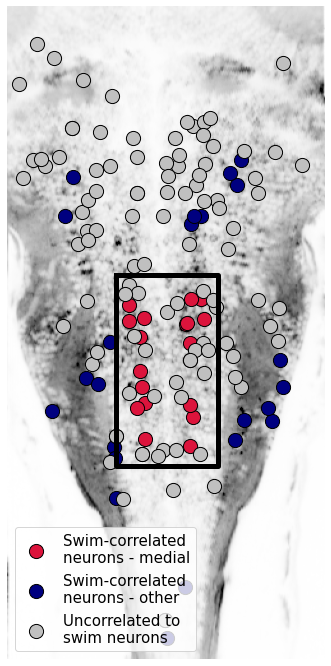

In [13]:
""" (A) The population calcium imaging data was acquired in vivo using a laser scanning two-photon calcium imaging 
    at 5.81 Hz at single-cell resolution of the hindbrain of Tg(HUC:GCaMP5G) transgenic larvae during active 
    visuomotor behavior (data from [33]). Neurons (n = 139) in a given plane of the larval zebrafish hindbrain 
    selected for analysis. The activity of neurons depicted in colors was correlated to motor: the red neurons 
    located in the medial rectangle are in the location of the V2a stripe (n = 20), and all other motor-correlated
    neurons are depicted in blue (n = 27). The activity of neurons depicted in gray (n = 112) are not correlated 
    to the motor output. 
"""

fig, ax = plt.subplots(figsize=(6,12))
plt.imshow(background.T, cmap=plt.cm.gist_yarg, aspect='equal', vmax=np.max(background)/2)

medial_mask = np.zeros(len(cell_centers), dtype=bool)
medial_mask[medial_neurons] = True
medial_centers = cell_centers[medial_mask]

swim_mask = np.zeros(len(cell_centers), dtype=bool)
swim_mask[only_swim_neurons] = True
swim_centers = cell_centers[swim_mask]

notswim_mask = np.ones(len(cell_centers), dtype=bool)
notswim_mask[swim_neurons] = False
notswim_centers = cell_centers[notswim_mask]

plt.scatter(medial_centers[:,1], 512 - medial_centers[:,0], color='crimson', edgecolor='black', s=200, label='Swim-correlated\nneurons - medial')
plt.scatter(swim_centers[:,1], 512 - swim_centers[:,0], color='navy', edgecolor='black', s=200, label='Swim-correlated\nneurons - other')
plt.scatter(notswim_centers[:,1], 512 - notswim_centers[:,0], color='silver', edgecolor='black', s=200, label='Uncorrelated to\nswim neurons')
#plt.scatter(512 - cell_centers[swim_neurons,0], cell_centers[swim_neurons,1], color='crimson', edgecolor='black', s=100)

#add legend to plot
plt.legend(fontsize=15)          

# Coordinates of rectangle vertices
# in clockwise order
xs = [85, 165, 165, 85, 85]
ys = [210, 210, 360, 360, 210]
ax.plot(xs, ys, color="k", linewidth=5)


    
plt.tight_layout
plt.axis('off')
plt.show()

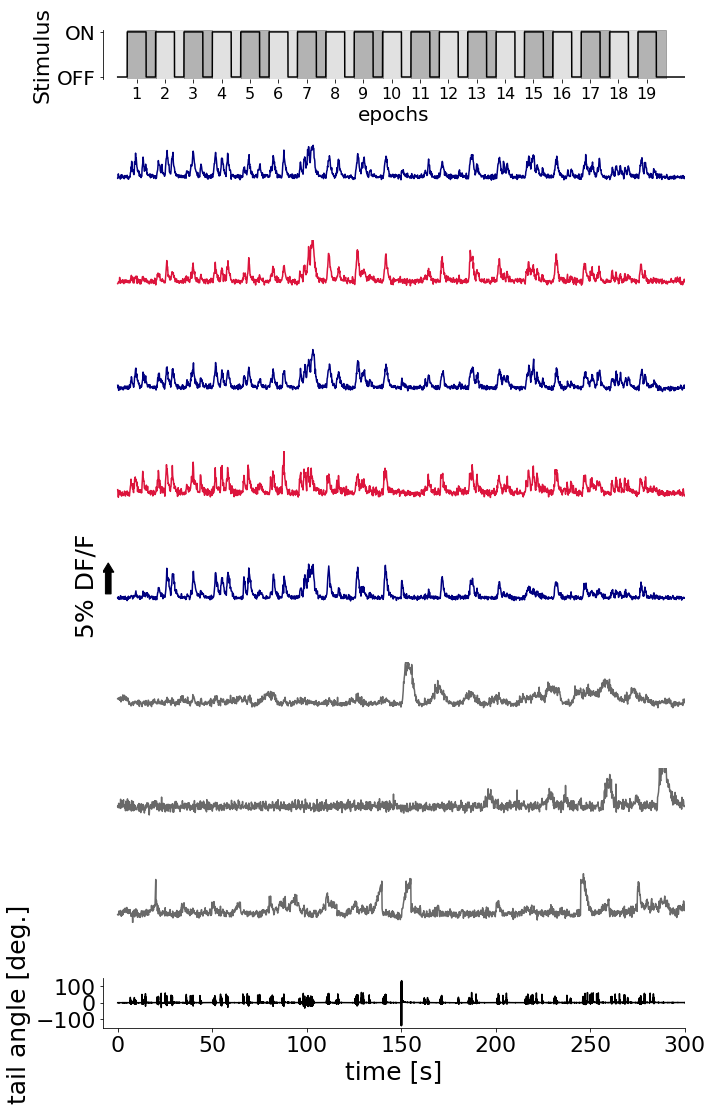

In [33]:
""" 
    (B) Example of calcium traces for the motor-correlated medial neurons (red), other motor-correlated
    neurons (blue) and non-motor correlated neurons (gray), ordered from top to bottom by their decreasing
    signal-to-noise ratio (SNR). The optomotor stimulus is depicted on top while the tail angle illustrating
    the motor output is depicted at the bottom. 
"""
GC_all = df_hindbrain.BV_GC_all.copy()  # we ran BVGC on all neurons as well.
drive = np.nansum(GC_all, axis=1)

i = 1
fig = plt.figure(figsize=(10,15))
plt.subplot(10,1,i)
plt.plot(xAx_stimulus, stim, color='k')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
xticklabels = [int(stim_start[i]+(stim_end[0]-stim_start[0])/2) for i in range(len(stim_start))]
plt.xticks(xticklabels, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'], fontsize=16)
plt.xlabel('epochs', fontsize=20)
plt.xlim([-8,300])
plt.yticks([np.min(stim), np.max(stim)], ['OFF', 'ON'], size=20)
plt.ylabel('Stimulus', size=22)

cycle_len = stim_start[1] - stim_start[0]
for st in range(len(stim_start[::2])):
    plt.axvspan(stim_start[2*st], stim_start[2*st]+cycle_len, color='dimgray', alpha=0.5)
    if st != len(stim_start[::2])-1:
        plt.axvspan(stim_start[2*st+1], stim_start[2*st+1]+cycle_len, color='dimgray', alpha=0.2)


i = i+1
for n in np.argsort(-drive)[:5]:
    plt.subplot(10,1,i)
    if n in medial_neurons:
        color = 'crimson'
    elif n in swim_neurons:
        color = 'navy'
    else:
        color = 'dimgray'
    plt.plot(xAx_calcium, zscore(df_hindbrain.fluo[n]), label=f'neuron {i}', color=color)
    plt.ylim([-2,6])
    plt.xlim([-8,300])
    plt.axis('off')
    i = i+1
    
plt.axis('on')
plt.xticks([])
ax = fig.axes[i-2]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.arrow(-5, 0, 0, 5, width=3, head_length=1.5, head_width=6, color='k', length_includes_head=True)
plt.ylabel('5% DF/F ', size=25)
plt.yticks([])    

for n in np.argsort(-drive)[-3:]:
    plt.subplot(10,1,i)
    if n in medial_neurons:
        color = 'crimson'
    elif n in swim_neurons:
        color = 'navy'
    else:
        color = 'dimgray'
    plt.plot(xAx_calcium, zscore(df_hindbrain.fluo[n]), label=f'neuron {i}', color=color)
    plt.ylim([-2,6])
    plt.xlim([-8,300])
    plt.axis('off')
    i = i+1



plt.subplot(10,1,i)
plt.plot(xAx_tail, df_hindbrain.tail_angle, color='k')        
plt.tight_layout()
plt.xlabel('time [s]', size=25)
plt.ylabel('tail angle [deg.]', size=25)
plt.xticks(size=22)
plt.yticks([-100, 0, 100], size=22)
plt.xlim([-8,300])
#.get_yaxis().set_visible(False)
ax = fig.axes[-1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout() 
plt.show()



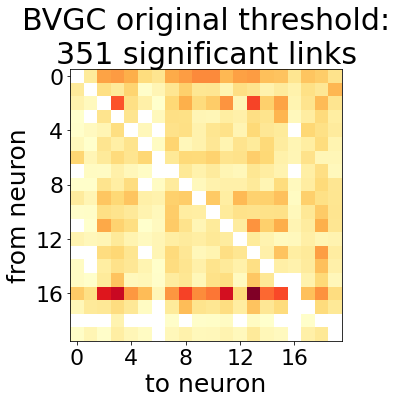

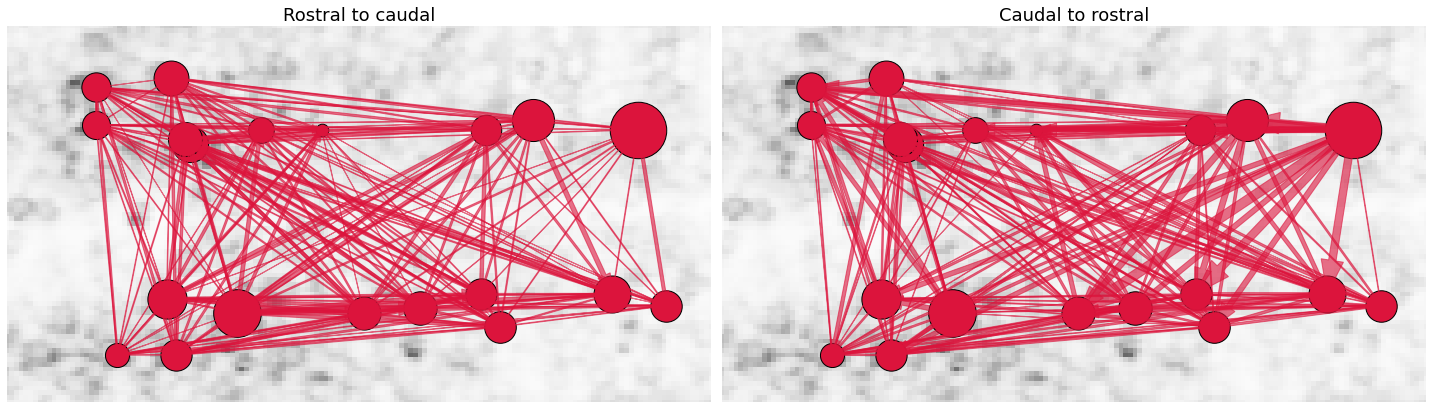

In [14]:
"""
    (C) GC matrix and map of information flow for the naive BVGC on medial motor-correlated neurons. 351 out of 380
    possible pairs are found to have a significant drive. This almost fully-connected network suggests that the naive 
    BVGC algorithm is too permissive to false positive links, and an adapted pipeline is needed to clean out the
    many spurious connections.
"""

# If you didn't run the GC, uncomment following lines: 
# gc = df_hindbrain.BV_GC_medial
# fstat = df_hindbrain.BV_Fstat_medial 
# threshold_F_ori = df_hindbrain.BV_threshold_F_ori 

gc_sig_original = get_GC_sig(gc, fstat, threshold_F_ori)

plt.figure(figsize=(5,5))
n_sig = len([i  for j in gc_sig_original for i in j if i>0])
plt.imshow(gc_sig_original, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'BVGC original threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,20,4), size=22) 
plt.yticks(np.arange(0,20,4), size=22) 
plt.show()

plot_info_flow_HB(gc_sig_original, cell_centers[medial_neurons], background, fish)
plt.tight_layout()
plt.show()

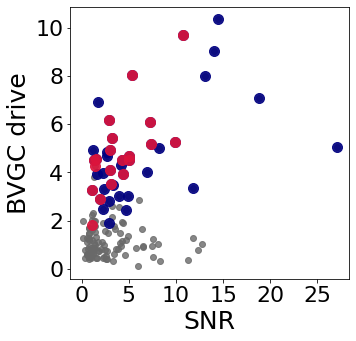

In [15]:
"""
    (D) The neuronal drive, calculated as the sum of the strength of all outgoing GC links for each neuron, is 
    correlated to the SNR of the calcium traces. It is especially high for medial neurons (r = 0.69, compared to
    r = 0.45 across all 139 neurons).
"""
GC_all = df_hindbrain.BV_GC_all.copy()  # we ran BVGC on all neurons as well.
drive = np.nansum(GC_all, axis=1)

plt.figure(figsize=(5,5))
plt.scatter(df_hindbrain.SNR, drive, color='dimgray', alpha=0.8)
plt.scatter(df_hindbrain.SNR[swim_neurons], drive[swim_neurons], color='navy', s=100, alpha=0.9)
plt.scatter(df_hindbrain.SNR[medial_neurons], drive[medial_neurons], color='crimson', s=100, alpha=0.9)
plt.xlabel('SNR', size=25)
plt.ylabel('BVGC drive', size=25)
plt.xticks(size=22)
plt.yticks(size=22)
plt.show()

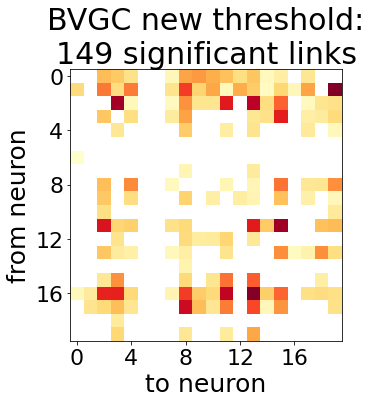

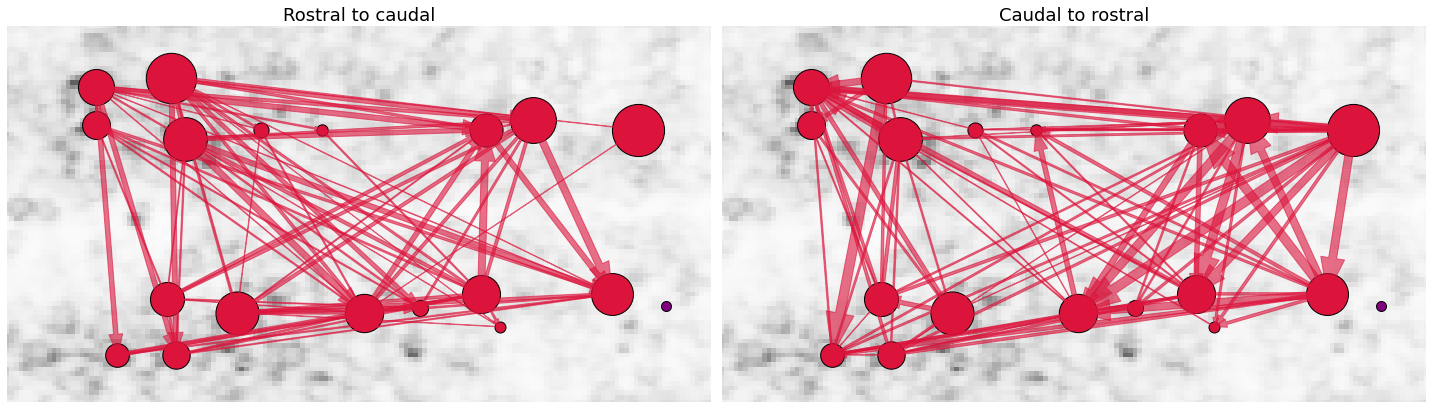

In [16]:
"""
    (E) After we customized the threshold and normalized the GC values, we obtain a network with fewer remaining 
    significant GC links, succeeding in removing many (spurious) links. We notice that the information flow was not
    unidirectional: links are rostral-to-caudal and caudal-to-rostral, as well as ipsilateral and contralateral, 
    showing strong information flow between the medial motor-correlated neurons.
"""
cst = 8000

# If you didn't run the GC, uncomment following line: 
# gc_normalized = df_hindbrain.BV_GC_normalized_medial 
# fstat =  df_hindbrain.BV_Fstat_medial 
# threshold_F_new = df_hindbrain.BV_threshold_F_new_mat_medial
# cst = 800

gc_normalized_sig_new = get_GC_sig(gc_normalized, fstat, threshold_F_new)

plt.figure(figsize=(5,5))
n_sig = len([i  for j in gc_normalized_sig_new for i in j if i>0])
plt.imshow(gc_normalized_sig_new, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'BVGC new threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,20,4), size=22) 
plt.yticks(np.arange(0,20,4), size=22) 
plt.show()

plot_info_flow_HB(gc_normalized_sig_new, cell_centers[medial_neurons], background, fish, cst=cst)
plt.tight_layout()
plt.show()

0.49316128252362257
0.6927305993316063


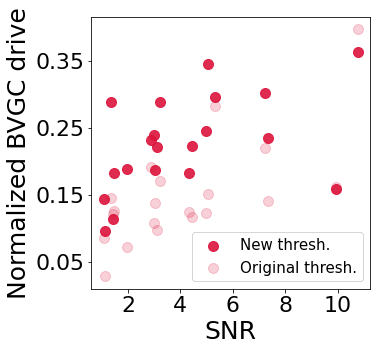

In [17]:
""" 
    (F) When computing the drive on the GC normalized by the new threshold, the correlation with the SNR decreases 
    from 0.69 to 0.49 for medial neurons.
"""

drive_med = np.nansum(gc, axis=1)
normalized_drive_med = np.nansum(gc_normalized, axis=1)

plt.figure(figsize=(5,5))
plt.scatter(df_hindbrain.SNR[medial_neurons], normalized_drive_med, color='crimson', s=100, alpha=0.9, label='New thresh.')
plt.scatter(df_hindbrain.SNR[medial_neurons], drive_med/threshold_F_ori, color='crimson', s=100, alpha=0.2, label='Original thresh.')
plt.xlabel('SNR', size=25)
plt.ylabel('Normalized BVGC drive', size=25)
plt.xticks(size=22)
plt.yticks([0.05, 0.15, 0.25, 0.35], size=22)
title = 'BVGC normalized drive vs SNR'
plt.legend(fontsize=15)

print(pearsonr(df_hindbrain.SNR[medial_neurons], normalized_drive_med)[0])
print(pearsonr(df_hindbrain.SNR[medial_neurons], drive_med/threshold_F_ori)[0])
plt.show()


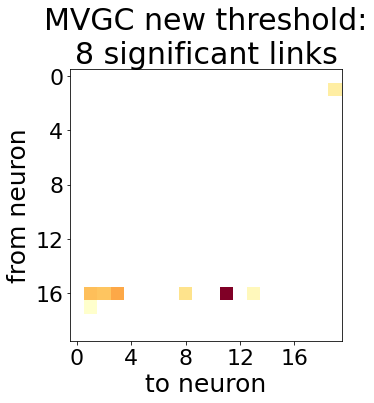

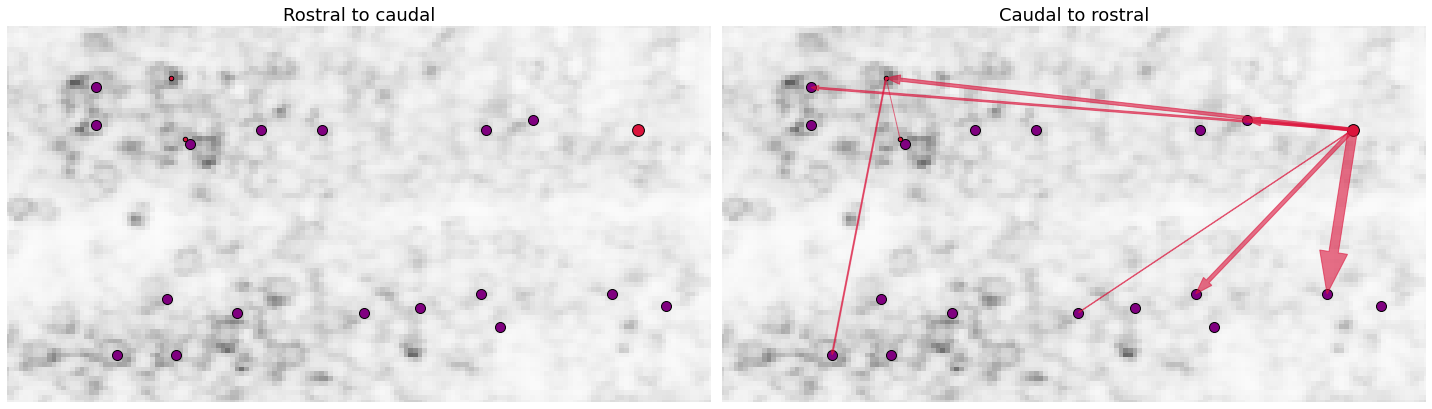

In [21]:
"""
    (G) The pipeline applied to MVGC removes too many links due to the high correlation in the data (all neurons 
    are motor-correlated) and relatively high number of neurons (20).
"""

# If you didn't run the GC, uncomment following lines: 
# Note that it can slightly vary depending on the random shuffles.
# Should be ~constant for large nmc.
# MV_gc_normalized = df_hindbrain.MV_GC_normalized_medial 
# MV_fstat =  df_hindbrain.MV_Fstat_medial 
# MV_threshold_F_new = df_hindbrain.MV_threshold_F_new_mat_medial


MV_gc_normalized_sig_new = get_GC_sig(MV_gc_normalized, MV_fstat, MV_threshold_F_new)

plt.figure(figsize=(5,5))
n_sig = len([i  for j in MV_gc_normalized_sig_new for i in j if i>0])
plt.imshow(MV_gc_normalized_sig_new, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'MVGC new threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,20,4), size=22) 
plt.yticks(np.arange(0,20,4), size=22) 
plt.show()

plot_info_flow_HB(MV_gc_normalized_sig_new, cell_centers[medial_neurons], background, fish)
plt.tight_layout()
plt.show()

### Supplementary figure S8

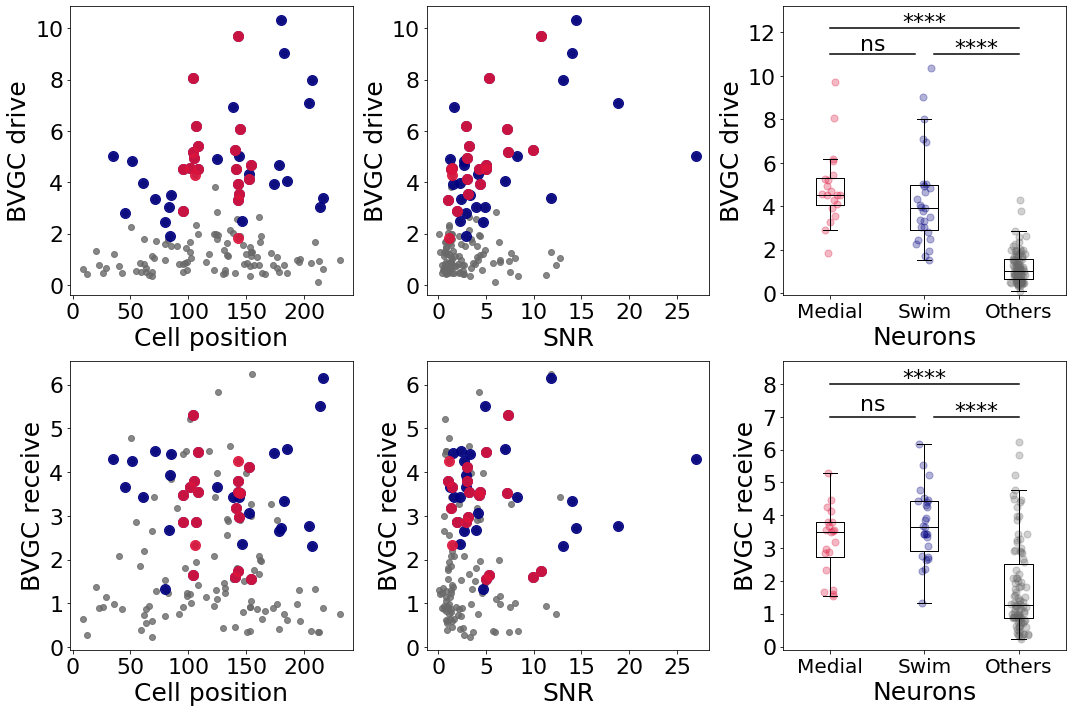

In [22]:
"""
    Correlation of the drive and receiving values to the cell position and signal-to-noise ratio and comparison across
neuron groups. (A) The neuronal drive, calculated as the sum of the strength of all outgoing Granger causality (GC) links for
each neuron, is not correlated to the neuron position. In data recorded by a two-photon laser scanning microscope, different
pixels are scanned across the sample with a very small delay. Panel A shows that the scanning direction and delay do not
influence the GC results. (B) The neuronal drive is correlated to the signal-to-noise ratio (SNR) of the calcium traces. It is
especially high for medial neurons (in red, r = 0.69 compared to r = 0.45 across all 139 neurons). After computing the new
threshold for significance with a corrected null hypothesis and the normalized GC values, the correlation between the drive
and SNR decreased. (C) The neuronal drive is significantly higher for motor-correlated neurons than for other neurons. This
observation suggests that motor-correlated neurons are important drivers of the network activity. (D) The receiving value of
a given neuron is defined as the sum of all its incoming GC links. As for the drive, it is not correlated to the cell position.
(E) The receiving value is correlated to the SNR. This correlation is reduced when computing the receiving value using the
normalized GC values. (F) The receiving value is significantly higher for motor-correlated than for other neurons. This shows
strong information flow between the motor-correlated neurons.
"""


GC_all = df_hindbrain.BV_GC_all.copy()  # we ran BVGC on all neurons as well.
drive = np.nansum(GC_all, axis=1)
receive = np.nansum(GC_all, axis=0)



fig, ax = plt.subplots(2,3,figsize=(15,10))
plt.subplot(231)
plt.scatter(cell_centers[:,1], drive, color='dimgray', alpha=0.8)
plt.scatter(cell_centers[swim_neurons,1], drive[swim_neurons], color='navy', s=100, alpha=0.9)
plt.scatter(cell_centers[medial_neurons,1], drive[medial_neurons], color='crimson', s=100, alpha=0.9)
plt.xlabel('Cell position', size=25)
plt.ylabel('BVGC drive', size=25)
plt.xticks(size=22)
plt.yticks(size=22)

plt.subplot(232)
plt.scatter(df_hindbrain.SNR, drive, color='dimgray', alpha=0.8)
plt.scatter(df_hindbrain.SNR[swim_neurons], drive[swim_neurons], color='navy', s=100, alpha=0.9)
plt.scatter(df_hindbrain.SNR[medial_neurons], drive[medial_neurons], color='crimson', s=100, alpha=0.9)
plt.xlabel('SNR', size=25)
plt.ylabel('BVGC drive', size=25)
plt.xticks(size=22)
plt.yticks(size=22)


plt.subplot(234)
plt.scatter(cell_centers[:,1], receive, color='dimgray', alpha=0.8)
plt.scatter(cell_centers[swim_neurons,1], receive[swim_neurons], color='navy', s=100, alpha=0.9)
plt.scatter(cell_centers[medial_neurons,1], receive[medial_neurons], color='crimson', s=100, alpha=0.9)
plt.xlabel('Cell position', size=25)
plt.ylabel('BVGC receive', size=25)
plt.xticks(size=22)
plt.yticks(size=22)

plt.subplot(235)
plt.scatter(df_hindbrain.SNR, receive, color='dimgray', alpha=0.8)
plt.scatter(df_hindbrain.SNR[swim_neurons], receive[swim_neurons], color='navy', s=100, alpha=0.9)
plt.scatter(df_hindbrain.SNR[medial_neurons], receive[medial_neurons], color='crimson', s=100, alpha=0.9)
plt.xlabel('SNR', size=25)
plt.ylabel('BVGC receive', size=25)
plt.xticks(size=22)
plt.yticks(size=22)


plt.subplot(233)
data = [drive[medial_neurons], drive[only_swim_neurons], drive[other_neurons]]
bp = ax[0][2].boxplot(data, showfliers=False)#, patch_artist =True)
plt.xticks([1,2,3], ["Medial", "Swim", "Others"], fontsize=20)
plt.yticks(fontsize=22)
plt.xlabel("Neurons", size=25)
plt.ylabel("BVGC drive", size=25)


box_colors = ['crimson', 'navy', 'dimgray']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    plt.setp(bp['medians'][i], color='k') 

for i, d in enumerate(data):
    y = data[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, alpha=0.3, color=box_colors[i], s=50)

plt.plot([1,1.9], [11,11], 'k-')
_, pval = mannwhitneyu(drive[medial_neurons], drive[only_swim_neurons])
plt.annotate(pval_to_star(pval), (2.9/2, 11.2), ha='center', size=22)

plt.plot([2.1,3], [11,11], 'k-')
_, pval = mannwhitneyu(drive[only_swim_neurons], drive[other_neurons])
plt.annotate(pval_to_star(pval), (5.1/2, 11), ha='center', size=22)

plt.plot([1,3], [12.2,12.2], 'k-')
_, pval = mannwhitneyu(drive[medial_neurons], drive[other_neurons])
plt.annotate(pval_to_star(pval), (4/2, 12.2), ha='center', size=22)
plt.ylim([-0.1, 13.2])


plt.subplot(236)
data = [receive[medial_neurons], receive[only_swim_neurons], receive[other_neurons]]
bp = ax[1][2].boxplot(data, showfliers=False)#, patch_artist =True)
plt.xticks([1,2,3], ["Medial", "Swim", "Others"], fontsize=20)
plt.yticks(fontsize=22)
plt.xlabel("Neurons", size=25)
plt.ylabel("BVGC receive", size=25)


box_colors = ['crimson', 'navy', 'dimgray']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    plt.setp(bp['medians'][i], color='k') 

for i, d in enumerate(data):
    y = data[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, alpha=0.3, color=box_colors[i], s=50)

plt.plot([1,1.9], [7,7], 'k-')
_, pval = mannwhitneyu(receive[medial_neurons], receive[only_swim_neurons])
plt.annotate(pval_to_star(pval), (2.9/2, 7.2), ha='center', size=22)

plt.plot([2.1,3], [7,7], 'k-')
_, pval = mannwhitneyu(receive[only_swim_neurons], receive[other_neurons])
plt.annotate(pval_to_star(pval), (5.1/2, 7), ha='center', size=22)

plt.plot([1,3], [8,8], 'k-')
_, pval = mannwhitneyu(receive[medial_neurons], receive[other_neurons])
plt.annotate(pval_to_star(pval), (4/2, 8), ha='center', size=22)
plt.ylim([-0.1, 8.7])

plt.tight_layout()
plt.show()



### Supplementary figure S9

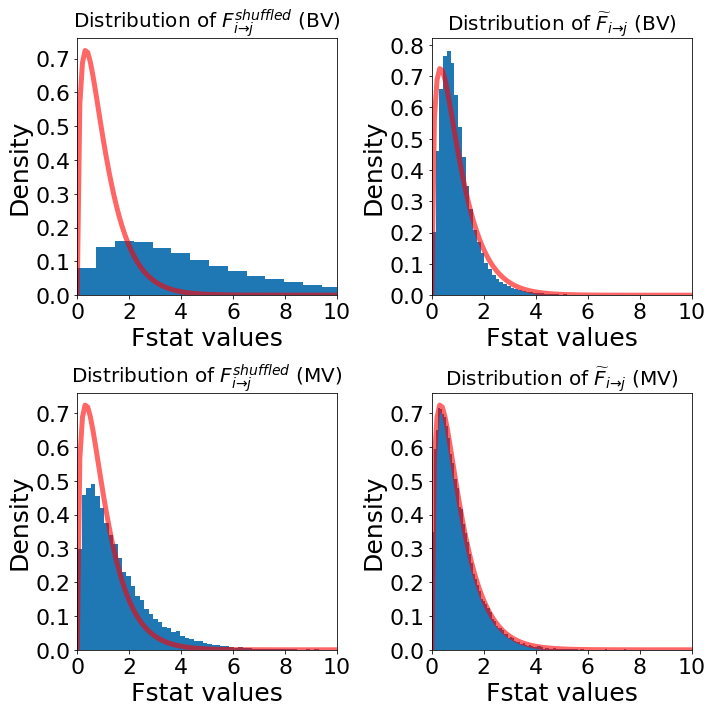

In [11]:
"""
     Distribution of the F -statistics of the shuffled data before and after re-scaling. (A) Original 
     distribution of the BVGC F-statistics of shuffled data Fshuffled i→j . It has a shifted support that 
     is larger than that of the F-distribution (red curve), meaning that if we use the original F-test based 
     on the F-distribution as a null model, even if there are no Granger-causal links between two neurons, 
     we will classify the link as significant. (B) For each neuron pair (i, j), the distribution Fshuffled
     i→j is well-described by a constant-rescaled F-distribution. Applying an adaptive threshold on Fi→j can
     be simplified to applying the original threshold on the normalized  ̃Fi→j , defined by dividing the naive 
     F-statistics with the expectation value of the F -statistics generated by the shuffled data 
     (  ̃Fi→j = Fi→j /⟨F shuffled i→j ⟩). (C) Original distribution of the MVGC Fshuffled i→j . (D) The normalized 
     Fshuffled i→j is almost perfectly described by a constant-rescaled F-distribution.
"""
# If you didn't run the GC, uncomment following lines: 
# with open(data_path + 'all_gcs_BV_sh_F6T07.pkl', 'rb') as pickle_in:
#     all_gcs_sh = pickle.load(pickle_in)  # idx = fish, plane

# with open(data_path + 'all_fstats_BV_sh_F6T07.pkl', 'rb') as pickle_in:
#     all_fstats_sh = pickle.load(pickle_in)  # idx = fish, plane, cell
    
# mean_F_sh = np.mean(all_fstats_sh, axis=2)

    
# with open(data_path + 'all_gcs_MV_sh_F6T07.pkl', 'rb') as pickle_in:
#     MV_all_gcs_sh = pickle.load(pickle_in)  # idx = fish, plane

# with open(data_path + 'all_fstats_MV_sh_F6T07.pkl', 'rb') as pickle_in:
#     MV_all_fstats_sh = pickle.load(pickle_in)  # idx = fish, plane, cell
    
# MV_mean_F_sh = np.mean(MV_all_fstats_sh, axis=2)

dfn = n_lags
dfd_BV = n_timesteps - 3 * n_lags - 1  # 2 cells involved + 1
dfd_MV = n_timesteps - (n_cells_med + 1) * n_lags - 1  # n_cells_med involved +1

nmc = all_fstats_sh.shape[-1]

all_fstats_sh_rescaled = np.zeros((n_cells_med, n_cells_med, nmc))

for i in range(n_cells_med):
    for j in range(n_cells_med):
        if i != j:
            for k in range(nmc):
                all_fstats_sh_rescaled[i,j,k] = all_fstats_sh[i,j,k] / mean_F_sh[i,j]


# before rescaling
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.hist(all_fstats_sh.flatten()[all_fstats_sh.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $F_{i \to j}^{shuffled}$ (BV)', size=20)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_BV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=25)
plt.xlabel('Fstat values', size=25)
plt.xticks(size=22)
plt.yticks(size=22)

plt.subplot(222)
plt.hist(all_fstats_sh_rescaled.flatten()[all_fstats_sh_rescaled.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $\widetilde{F}_{i\to j}$ (BV)', size=20)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_BV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=25)
plt.xlabel('Fstat values', size=25)
plt.xticks(size=22)
plt.yticks(size=22)
plt.tight_layout()




# before rescaling
plt.subplot(223)
plt.hist(MV_all_fstats_sh.flatten()[MV_all_fstats_sh.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $F_{i \to j}^{shuffled}$ (MV)', size=20)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_MV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=25)
plt.xlabel('Fstat values', size=25)
plt.xticks(size=22)
plt.yticks(size=22)

nmc = MV_all_fstats_sh.shape[-1]
MV_all_fstats_sh_rescaled = np.zeros((n_cells_med, n_cells_med, nmc))

for i in range(n_cells_med):
    for j in range(n_cells_med):
        if i != j:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = MV_all_fstats_sh[i,j,k] / MV_mean_F_sh[i,j]

# rescaled
plt.subplot(224)
plt.hist(MV_all_fstats_sh_rescaled.flatten()[MV_all_fstats_sh_rescaled.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $\widetilde{F}_{i\to j}$ (MV)', size=20)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_MV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=25)
plt.xlabel('Fstat values', size=25)
plt.xticks(size=22)
plt.yticks(size=22)

plt.tight_layout()
plt.show()